<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/ClimatePrediction/blob/master/Predict_Rain_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Nomes para as colunas
columns = ["Estacao","Data","Hora","Prec","TempMax","TempMin","Insolacao","EvapoPiche","TempCompMedia",
           "UmidRelatMedia", "VelocVento", "Missing"]

#Tipos de dados em cada coluna
types = {"Hora":np.uint16,"Prec":np.float64,"TempMax":np.float64,"TempMin":np.float64,"Insolacao":np.float64,
         "EvapoPiche":np.float64,"TempCompMedia":np.float64,"UmidRelatMedia":np.float64,"VelocVento":np.float64}

#Leitura do arquivo csv
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/ClimatePrediction/raw/master/Dados_INMET/Diarios/INMET-Dados_Diarios_Natal_1968-2018.csv",
                      sep=';',skiprows=48, nrows = 27003, usecols = columns[1:11], names=columns, dtype = types)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Verificando dados
dataSet.head()

,Data,Hora,Prec,TempMax,TempMin,Insolacao,EvapoPiche,TempCompMedia,UmidRelatMedia,VelocVento
0,1968-01-01,0,NaN,30.6,NaN,11.1,4.4,25.14,73.50,2.666667
1,1968-01-01,1200,0.0,NaN,21.4,NaN,NaN,NaN,NaN,NaN
2,1968-01-02,0,NaN,31.0,NaN,11.9,6.5,24.92,74.75,1.666667
3,1968-01-02,1200,0.0,NaN,19.6,NaN,NaN,NaN,NaN,NaN
4,1968-01-03,0,NaN,31.6,NaN,11.3,5.0,24.90,77.25,2.333333


In [5]:
#Verificando o tipo dos dados
dataSet.dtypes

Data              datetime64[ns]
Hora                      uint16
Prec                     float64
TempMax                  float64
TempMin                  float64
Insolacao                float64
EvapoPiche               float64
TempCompMedia            float64
UmidRelatMedia           float64
VelocVento               float64
dtype: object

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [7]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.head()

,Data,Hora,Prec,TempMax,TempMin,Insolacao,EvapoPiche,TempCompMedia,UmidRelatMedia,VelocVento
0,1968-01-01,0,NaN,30.6,NaN,11.1,4.4,25.14,73.50,2.666667
2,1968-01-02,0,NaN,31.0,NaN,11.9,6.5,24.92,74.75,1.666667
4,1968-01-03,0,NaN,31.6,NaN,11.3,5.0,24.90,77.25,2.333333
6,1968-01-04,0,NaN,31.2,NaN,10.3,4.0,24.82,80.75,3.666667
8,1968-01-05,0,NaN,30.8,NaN,11.0,4.2,24.78,76.00,4.000000


In [8]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.head()

,Data,Hora,Prec,TempMax,TempMin,Insolacao,EvapoPiche,TempCompMedia,UmidRelatMedia,VelocVento
1,1968-01-01,1200,0.0,NaN,21.4,NaN,NaN,NaN,NaN,NaN
3,1968-01-02,1200,0.0,NaN,19.6,NaN,NaN,NaN,NaN,NaN
5,1968-01-03,1200,0.0,NaN,18.5,NaN,NaN,NaN,NaN,NaN
7,1968-01-04,1200,0.0,NaN,20.7,NaN,NaN,NaN,NaN,NaN
9,1968-01-05,1200,0.0,NaN,19.9,NaN,NaN,NaN,NaN,NaN


In [0]:
#Transformando a data no índice de cada dataframe
dataSet00 = dataSet00.set_index("Data")
dataSet12 = dataSet12.set_index("Data")

In [0]:
#Descartando a coluna "Hora"
dataSet00, dataSet12 = dataSet00.drop(columns = "Hora"), dataSet12.drop(columns = "Hora")

In [11]:
#Juntando os dados em um mesmo dataframe (no caso, o dataSet00)
for i in dataSet00.index:
    try:
        dataSet00["Prec"].loc[i] = dataSet12["Prec"].loc[i]
        dataSet00["TempMin"].loc[i] = dataSet12["TempMin"].loc[i]
    except:
        print("Data " + str(i.day) + "/" + str(i.month) + "/" + str(i.year) + " Não encontrada!")

Data 5/7/1986 Não encontrada!
Data 20/7/1986 Não encontrada!
Data 3/6/1989 Não encontrada!
Data 12/6/1989 Não encontrada!
Data 4/12/1992 Não encontrada!
Data 26/5/2018 Não encontrada!
Data 1/8/2018 Não encontrada!
Data 27/10/2018 Não encontrada!


In [12]:
#Atribuindo à variável dataSet o DataFrame atualizado
dataSet = dataSet00
#Verificando dimensões do DataFrame
print(dataSet.shape)

(13502, 8)


In [0]:
#Transformando a coluna Data de volta em uma coluna de informações do dataSet
dataSet = dataSet.reset_index()

In [14]:
#Eliminando da base de dados dias que não tenham ao menos 5 das variáveis no dataSet
#dataSet = dataSet.dropna(thresh=5)
#Eliminando da base de dados dias com variáveis faltantes
dataSet = dataSet.dropna()
#Exibindo novas dimensões da base de dados
print(dataSet.shape)

(13455, 9)


# Considerando os seguintes intervalos: 
- Outono: 20 de março a 21 de junho (fechado em 20/03 e aberto em 21/06)
- Inverno: 21 de junho a 22 de setembro (fechado em 21/06 e aberto em 22/09)
- Primavera: de 22 de setembro a 21 de dezembro (fechado em 22/09 e aberto em 21/12)
- Verão: de 21 de dezembro a 20 de março (fechado em 21/12 e aberto em 20/03)

In [0]:
#Função que retorna a estação do ano para uma determinada data, para ser adicionada à base de dados
def season(data):
    if (data.month > 3 and data.month < 6) or (data.month == 3 and data.day >= 20) or (data.month == 6 and data.day < 21):
        return "Out"
    if (data.month > 6 and data.month < 9) or (data.month == 6 and data.day >= 21) or (data.month == 9 and data.day < 22):
        return "Inv"
    if (data.month > 9 and data.month < 12) or (data.month == 9 and data.day >= 22) or (data.month == 12 and data.day < 21):
        return "Pri"
    else:
        return "Ver"

In [0]:
#Identificando a estação do ano na base de dados e guardando a informação referente ao ano de cada dado
estacao = []
for i in dataSet.index:
    estacao.insert(i, season(dataSet.loc[i, "Data"]))

In [17]:
#Contando quantos dados existem para cada estação
print("Outono: " + str(estacao.count("Out")))
print("Inverno: " + str(estacao.count("Inv")))
print("Primavera: " + str(estacao.count("Pri")))
print("Verão: " + str(estacao.count("Ver")))

Outono: 3397
Inverno: 3460
Primavera: 3337
Verão: 3261


In [18]:
#Eliminando a coluna "Data" e visualizando dados
dataSet = dataSet.drop(columns="Data")
dataSet.head()

,Prec,TempMax,TempMin,Insolacao,EvapoPiche,TempCompMedia,UmidRelatMedia,VelocVento
0,0.0,30.6,21.4,11.1,4.4,25.14,73.50,2.666667
1,0.0,31.0,19.6,11.9,6.5,24.92,74.75,1.666667
2,0.0,31.6,18.5,11.3,5.0,24.90,77.25,2.333333
3,0.0,31.2,20.7,10.3,4.0,24.82,80.75,3.666667
4,0.0,30.8,19.9,11.0,4.2,24.78,76.00,4.000000


In [0]:
#Decodificando as estações em uma matriz (one hot encoding - dummy variables)
encoder = LabelEncoder()
encoder.fit(estacao)
encodedSeason = encoder.transform(estacao)
dummySeason = np_utils.to_categorical(encodedSeason)

In [20]:
#Identificar como aconteceu a transformação
auxSeason = encoder.transform(["Inv","Out","Pri","Ver"])
auxDummy = np_utils.to_categorical(auxSeason)
print("[Inv,Out,Pri,Ver]")
print(auxDummy)

[Inv,Out,Pri,Ver]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [0]:
#Separando a variável que será prevista, precipitação, da base de dados
prec = dataSet["Prec"]
dataSet = dataSet.drop(columns = "Prec")

In [0]:
#Adicionando ao dataSet as informações de estação climática
dataSet["Inv"] = dummySeason[:,0]
dataSet["Out"] = dummySeason[:,1]
dataSet["Pri"] = dummySeason[:,2]
dataSet["Ver"] = dummySeason[:,3]

In [23]:
#Visualizando dados
dataSet.head()

,TempMax,TempMin,Insolacao,EvapoPiche,TempCompMedia,UmidRelatMedia,VelocVento,Inv,Out,Pri,Ver
0,30.6,21.4,11.1,4.4,25.14,73.50,2.666667,0.0,0.0,0.0,1.0
1,31.0,19.6,11.9,6.5,24.92,74.75,1.666667,0.0,0.0,0.0,1.0
2,31.6,18.5,11.3,5.0,24.90,77.25,2.333333,0.0,0.0,0.0,1.0
3,31.2,20.7,10.3,4.0,24.82,80.75,3.666667,0.0,0.0,0.0,1.0
4,30.8,19.9,11.0,4.2,24.78,76.00,4.000000,0.0,0.0,0.0,1.0


In [0]:
#Separando conjunto de treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(dataSet, prec, test_size = 0.1, random_state = 9)

In [0]:
#Efetuando uma transformação robusta, trabalhando com os dados entre os percentis 10 e 90
rs = RobustScaler(quantile_range = (10.0,90.0))
X_train = rs.fit_transform(dataSet)
X_test = rs.transform(X_test)

In [0]:
#Trocando dados faltantes por 0
#dataSet = np.nan_to_num(dataSet, copy = False)
#prec = np.nan_to_num(prec, copy = False)

In [39]:
#Verificando dimensões do dataSet
print(dataSet.shape)

(13455, 11)


In [40]:
'''#Função para avaliar o desempenho da rede
def acerto(y_true, y_pred):
  try:
    print(y_true.eval())
    total = y_true.eval()
    acertos = 0

    for i in range(total):
      if (y_true[i] <= (y_pred[i] + 5)) and (y_true[i] >= (y_pred[i] - 5)):
        acertos += 1

    return (acertos / total)
  except:
    return 0
    '''

'#Função para avaliar o desempenho da rede\ndef acerto(y_true, y_pred):\n  try:\n    print(y_true.eval())\n    total = y_true.eval()\n    acertos = 0\n\n    for i in range(total):\n      if (y_true[i] <= (y_pred[i] + 5)) and (y_true[i] >= (y_pred[i] - 5)):\n        acertos += 1\n\n    return (acertos / total)\n  except:\n    return 0\n    '

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='rmsprop', init='normal', units = 11, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = 11, units = units, kernel_initializer = init))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer=init))    
  # Compilando o modelo
  mlp.compile(loss='mae',optimizer = optimizer, metrics= ['mse', 'acc'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 400)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=7)

In [0]:
#Treinando a rede
#estimator.fit(dataSet, prec)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [20, 32],             
              'camadas': [1,2,3]}

In [0]:
grid_search = GridSearchCV(estimator = estimator, param_grid = parameters, n_jobs = -1,
                       scoring = "neg_mean_absolute_error", verbose=2, cv = kfold, return_train_score = True)

In [47]:
prec

array([0., 0., 0., ..., 0., 0., 0.])

In [48]:
grid_result = grid_search.fit(dataSet, prec)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 48.8min finished


Epoch 1/200
13455/13455 [==============================] - 1s 58us/step - loss: 4.4051 - mean_squared_error: 181.3411 - acc: 0.4150
Epoch 2/200
13455/13455 [==============================] - 1s 48us/step - loss: 4.3422 - mean_squared_error: 174.2241 - acc: 0.3376
Epoch 3/200
13455/13455 [==============================] - 1s 48us/step - loss: 4.3238 - mean_squared_error: 172.1510 - acc: 0.3255
Epoch 4/200
13455/13455 [==============================] - 1s 47us/step - loss: 4.3115 - mean_squared_error: 170.2712 - acc: 0.3092
Epoch 5/200
13455/13455 [==============================] - 1s 48us/step - loss: 4.3016 - mean_squared_error: 168.8261 - acc: 0.3015
Epoch 6/200
13455/13455 [==============================] - 1s 48us/step - loss: 4.2791 - mean_squared_error: 167.4509 - acc: 0.3054
Epoch 7/200
13455/13455 [==============================] - 1s 47us/step - loss: 4.2180 - mean_squared_error: 164.3772 - acc: 0.3318
Epoch 8/200
13455/13455 [==============================] - 1s 47us/step - lo

In [49]:
print("Melhor resultado: %f, usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Best: -3.669920 using {'batch_size': 20, 'optimizer': 'rmsprop', 'units': 11}
-3.683627 (0.087387) with: {'batch_size': 20, 'optimizer': 'adam', 'units': 5}
-3.675229 (0.068590) with: {'batch_size': 20, 'optimizer': 'adam', 'units': 11}
-3.672389 (0.087125) with: {'batch_size': 20, 'optimizer': 'adam', 'units': 22}
-3.694954 (0.100129) with: {'batch_size': 20, 'optimizer': 'rmsprop', 'units': 5}
-3.669920 (0.081840) with: {'batch_size': 20, 'optimizer': 'rmsprop', 'units': 11}
-3.673383 (0.091741) with: {'batch_size': 20, 'optimizer': 'rmsprop', 'units': 22}
-3.693413 (0.085924) with: {'batch_size': 40, 'optimizer': 'adam', 'units': 5}
-3.680783 (0.089789) with: {'batch_size': 40, 'optimizer': 'adam', 'units': 11}
-3.693335 (0.073886) with: {'batch_size': 40, 'optimizer': 'adam', 'units': 22}
-3.707034 (0.088895) with: {'batch_size': 40, 'optimizer': 'rmsprop', 'units': 5}
-3.690766 (0.080827) with: {'batch_size': 40, 'optimizer': 'rmsprop', 'units': 11}
-3.697705 (0.094144) with: {'ba

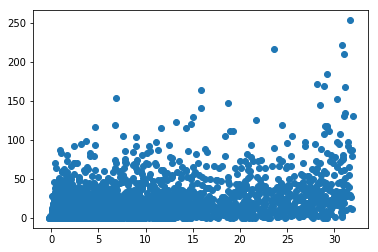

In [58]:
plt.scatter(grid_search.predict(dataSet), prec)

In [54]:
prec

array([0., 0., 0., ..., 0., 0., 0.])